In [1]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import networkx as nx


from torch.distributions import Categorical, Bernoulli


import json

from agents.option_critic import OptionCriticFeatures
from agents.option_critic_nn import OptionCriticNeuralNetwork
from agents.option_networks import TerminationFunctionNetwork

/home/ruben/Documents/virtualenv/vub_sdms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 2
PREFIX = 'option_critic_nn_custom-2way-single-intersection'
MODEL = "./models/option_critic_nn_2_options_custom-2way-single-intersection_100800_steps"

In [3]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes


In [25]:
df_single_episode, _ = load_data(PREFIX)

<Axes: xlabel='step'>

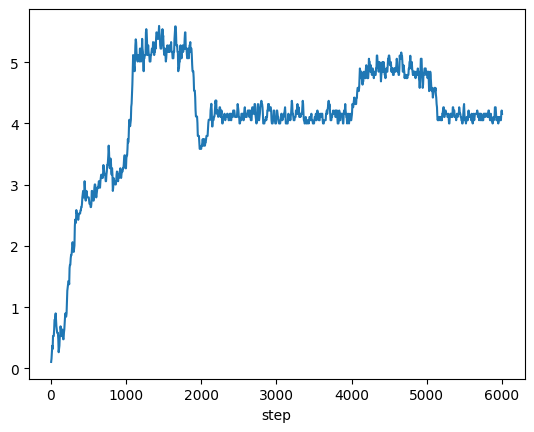

In [26]:
df_single_episode.lane_density.plot()

<Axes: xlabel='step'>

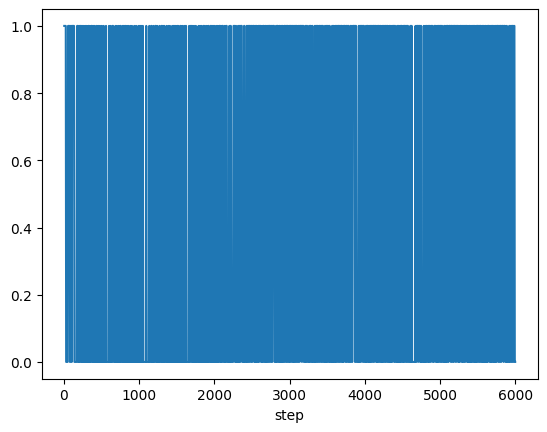

In [27]:
df_single_episode.option.plot()

In [28]:
df_single_episode

,option,action,obs,termination_prob,should_terminate,greedy_option,average_cumulative_reward,waiting_time,speed,lane_density,queue_length
step,,,,,,,,,,,
5.0,1,2,"{""t"": {""current_time"": [5.0], ""phase_ids"": [1,...",0.731059,True,1,-0.000088,0.000000,15.090042,0.105671,0
10.0,1,2,"{""t"": {""current_time"": [10.0], ""phase_ids"": [1...",0.731059,False,1,-0.000304,0.000000,11.489685,0.158507,0
15.0,1,1,"{""t"": {""current_time"": [15.0], ""phase_ids"": [0...",0.731059,True,1,-0.000995,0.600000,6.916172,0.264178,2
20.0,1,2,"{""t"": {""current_time"": [20.0], ""phase_ids"": [0...",0.731059,False,0,-0.002268,1.857143,9.126587,0.369849,2
25.0,1,2,"{""t"": {""current_time"": [25.0], ""phase_ids"": [0...",0.731059,True,0,-0.003995,1.375000,9.916749,0.317013,1
...,...,...,...,...,...,...,...,...,...,...,...
5980.0,1,2,"{""t"": {""current_time"": [5980.0], ""phase_ids"": ...",0.731059,True,1,-260.894457,5134.615385,0.172387,4.052836,77
5985.0,1,2,"{""t"": {""current_time"": [5985.0], ""phase_ids"": ...",0.731059,True,1,-261.133439,5074.405063,0.432838,4.052836,76
5990.0,1,2,"{""t"": {""current_time"": [5990.0], ""phase_ids"": ...",0.731059,True,0,-261.372489,5015.725000,0.667539,4.158507,76


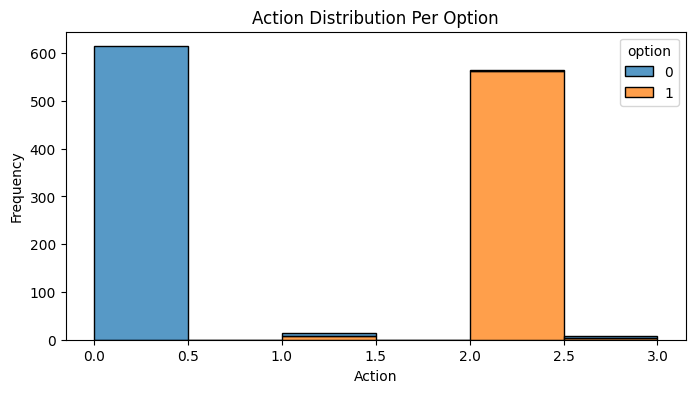

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="action", hue="option", multiple="stack", palette="tab10", bins=6)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

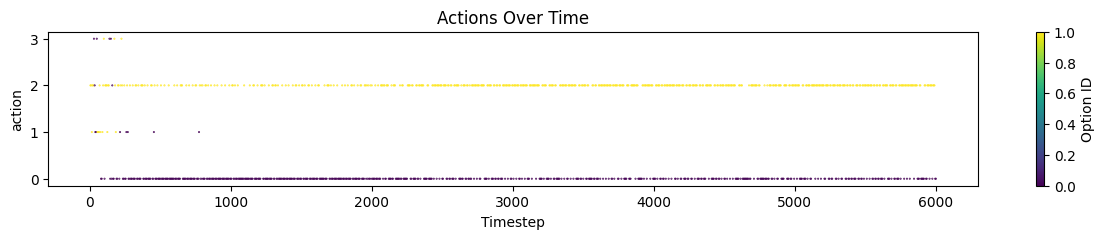

In [30]:
plt.figure(figsize=(15, 2))
plt.scatter(df_single_episode.index, df_single_episode.action, c=df_single_episode.option, s=0.2)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

Drawing graph


/home/ruben/Documents/virtualenv/vub_sdms/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


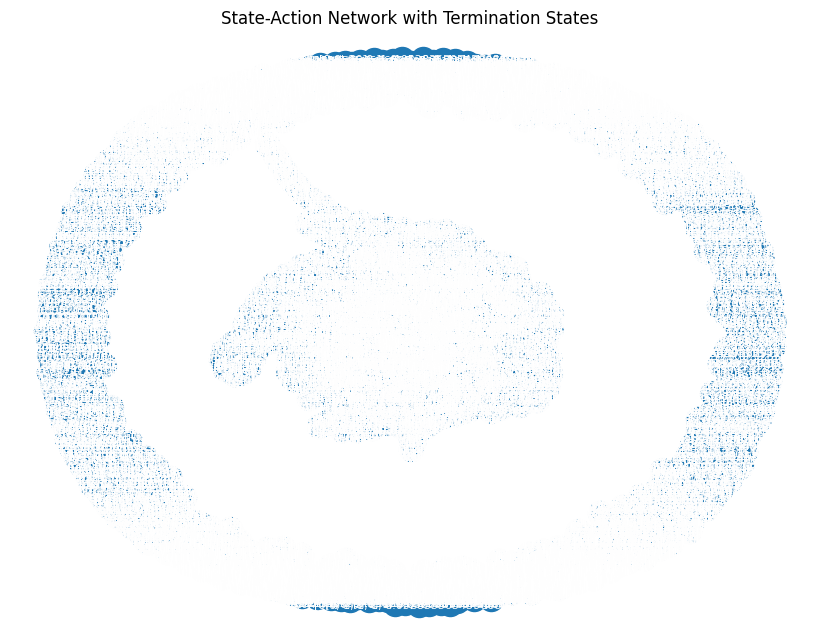

In [10]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
observation_dict = list(json.loads(df_single_episode.obs.to_list()[0]).values())[0]
current_time = observation_dict["current_time"]
phase_id = observation_dict["phase_id"]
min_green = observation_dict["min_green"]
density = observation_dict["density"]
queue = observation_dict["queue"]
delta_queue = observation_dict["delta_queue"]
observation = np.array(current_time + phase_id + min_green + density + queue + delta_queue, dtype=np.float32)


model_params = torch.load(MODEL)['model_params']
agent = OptionCriticNeuralNetwork(
    in_features=len(observation),
    num_actions=4,
    num_options=2,
    temperature=0.1,
    eps_start=0.9,
    eps_min=0.1,
    eps_decay=0.999,
    eps_test=0.05,
    device="cpu",
)
agent.load_state_dict(
    torch.load(
        MODEL
    )["model_params"]
)

In [ ]:
current_option = df_single_episode.option.to_list()[0]
encoded_option = np.zeros(2)
encoded_option[current_option] = 1
obs = np.append(observation, encoded_option)
    
state = agent.get_state(obs)
state = state.clone().detach().requires_grad_(True)

# Forward pass
termination_prob = agent.terminations(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(10, 10))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [ ]:
# TODO: unnest observation dict 